<img src="https://ww2.ufps.edu.co/public/archivos/elementos_corporativos/logoufps.png" style="float: left; margin: 20px; height: 55px">  

<b> <font size='5'>  
HYBRID MODEL BASED ON ARTIFICIAL INTELLIGENCE FOR ENERGY DISPATCH IN A MICROGRID</font>  

<font size='4'> Dispatch algorithm Notebook</font> </b>

<font size='3'>  
&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; 2023<br>
</font>

---

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
plt.rcParams['font.sans-serif'] = ['Times New Roman']
plt.rcParams['font.serif'] = ['Times New Roman']

In [20]:
df_PV = pd.DataFrame(pd.read_csv('./6a_Predictions_PV.csv'))
df_Demand = pd.DataFrame(pd.read_csv('./6b_Predictions_Demand.csv'))
df_Wind = pd.DataFrame(pd.read_csv('./6c_Predictions_Wind.csv'))

In [21]:
df_PV['Time'] = pd.to_datetime(df_PV['Time'], format='%Y-%m-%d %H:%M:%S')
df_PV= df_PV.set_index('Time')
df_PV= df_PV.asfreq('5min')
df_PV= df_PV.sort_index()
df_Demand['Time'] = pd.to_datetime(df_Demand['Time'], format='%Y-%m-%d %H:%M:%S')
df_Demand= df_Demand.set_index('Time')
df_Demand= df_Demand.asfreq('5min')
df_Demand= df_Demand.sort_index()
df_Wind['Time'] = pd.to_datetime(df_Wind['Time'], format='%Y-%m-%d %H:%M:%S')
df_Wind= df_Wind.set_index('Time')
df_Wind= df_Wind.asfreq('5min')
df_Wind= df_Wind.sort_index()

In [22]:
renewable_power = df_PV['predicciones_stacked'] + df_Wind['predicciones_stacked']
#renewable_power = (df_PV['predicciones_stacked']/0.2)*0.35 + (df_Wind['predicciones_stacked']/0.2)*0.35
renewable_power = pd.DataFrame(data={'Renewable':renewable_power})
renewable_power = renewable_power.resample(rule='H', closed='left', label ='right').mean()
#renewable_power.to_excel('./MicroGrids/Renewable_Energy2.xls')

In [23]:
df_Demand = df_Demand.resample(rule='H', closed='left', label ='right').mean()
demand = pd.DataFrame(data={'Demand':df_Demand['predicciones_stacked']})
#demand.to_excel('./MicroGrids/Demand2.xls')

In [24]:
battery_size = 20000 #MW
battery = 20000
battery_in = []
battery_out = []
battery_status = []
grid_purchases = []
DOD = 0.25

for i in range(0,len(renewable_power)):
    if demand.iloc[i]['Demand'] < renewable_power.iloc[i]['Renewable']:
        battery_in.append(min(renewable_power.iloc[i]['Renewable']-demand.iloc[i]['Demand'],battery_size))
        battery_out.append(0)
        battery = min(battery + battery_in[i],battery_size)
        grid_purchases.append(0)
        battery_status.append(battery)
    elif demand.iloc[i]['Demand'] < renewable_power.iloc[i]['Renewable'] + battery and battery-(demand.iloc[i]['Demand']-renewable_power.iloc[i]['Renewable']) > battery_size*DOD:
        battery_in.append(0)
        battery_out.append(demand.iloc[i]['Demand']-renewable_power.iloc[i]['Renewable'])
        battery = max(battery-(demand.iloc[i]['Demand']-renewable_power.iloc[i]['Renewable']),0)
        grid_purchases.append(0)
        battery_status.append(battery)
    elif demand.iloc[i]['Demand'] < renewable_power.iloc[i]['Renewable'] + battery and battery-(demand.iloc[i]['Demand']-renewable_power.iloc[i]['Renewable']) < battery_size*DOD:
        grid_purchases.append(demand.iloc[i]['Demand']-renewable_power.iloc[i]['Renewable'])
        battery_in.append(0)
        battery_out.append(0)
        battery_status.append(battery)
    elif demand.iloc[i]['Demand'] > renewable_power.iloc[i]['Renewable'] + battery and battery-(demand.iloc[i]['Demand']-renewable_power.iloc[i]['Renewable']) > battery_size*DOD:
        grid_purchases.append(demand.iloc[i]['Demand']-renewable_power.iloc[i]['Renewable']-battery)
        battery_in.append(0)
        battery_out.append(battery-(demand.iloc[i]['Demand']-renewable_power.iloc[i]['Renewable']))
        battery = battery_out[i]
        battery_status.append(battery)
    elif demand.iloc[i]['Demand'] > renewable_power.iloc[i]['Renewable'] + battery and battery-(demand.iloc[i]['Demand']-renewable_power.iloc[i]['Renewable']) < battery_size*DOD:
        grid_purchases.append(demand.iloc[i]['Demand']-renewable_power.iloc[i]['Renewable'])
        battery_in.append(0)
        battery_out.append(0)
        battery_status.append(battery)

In [25]:
dispatch_algorithm = pd.DataFrame(data={'Renewable energy':renewable_power['Renewable'],'Battery flow out':battery_out,'Battery flow in':battery_in,'Demand':demand['Demand'],'Battery status':battery_status,'Grid purchases':grid_purchases})

In [26]:
dispatch_algorithm['Battery flow in'] = dispatch_algorithm['Battery flow in']*-1
dispatch_algorithm['Battery percentage'] = (dispatch_algorithm['Battery status']/battery_size)*100

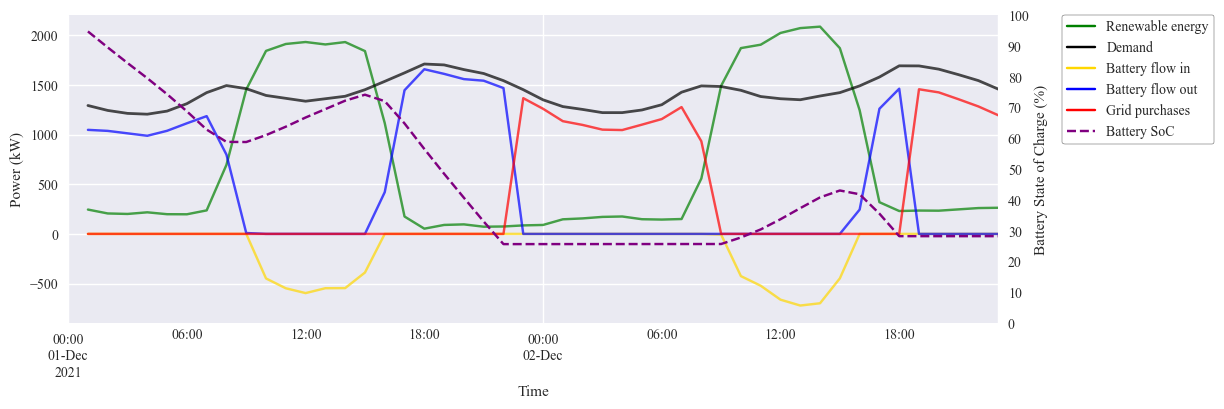

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))

dispatch_algorithm['Renewable energy'].plot(ax=ax, color='green',alpha=0.7)
dispatch_algorithm['Demand'].plot(ax=ax, linewidth=2,color='black',alpha=0.7)
dispatch_algorithm['Battery flow in'].plot(ax=ax, color='gold',alpha=0.7)
dispatch_algorithm['Battery flow out'].plot(ax=ax, color='blue',alpha=0.7)
dispatch_algorithm['Grid purchases'].plot(ax=ax, color='red',alpha=0.7)

'''
alpha = 0.3

barrier = dispatch_algorithm['Renewable energy'] + dispatch_algorithm['Grid purchases']

plt.fill_between(dispatch_algorithm.index,dispatch_algorithm['Renewable energy'],0,color='green',alpha=alpha)
#plt.fill_between(dispatch_algorithm.index,dispatch_algorithm['Demand'],0,color='green',alpha=alpha)
plt.fill_between(dispatch_algorithm.index,0,dispatch_algorithm['Battery flow in'],color='pink',alpha=alpha)
plt.fill_between(dispatch_algorithm.index,dispatch_algorithm['Demand'],barrier,color='blue',alpha=alpha, where=dispatch_algorithm['Battery flow out'] >= barrier)
plt.fill_between(dispatch_algorithm.index,dispatch_algorithm['Demand'],dispatch_algorithm['Renewable energy'],color='red',alpha=alpha, where=dispatch_algorithm['Grid purchases'] >= dispatch_algorithm['Renewable energy'])
'''

plt.xlim('2021-12-01 00:00','2021-12-02 23:55')
plt.ylabel('Power (kW)')
plt.ylim(-900,2200)
#plt.legend(frameon=True,edgecolor='black',facecolor='white',bbox_to_anchor=(1.23,0.625))

ax1 = ax.twinx()
dispatch_algorithm['Battery percentage'].plot(ax=ax1, color='purple', linestyle='dashed')
plt.xlim('2021-12-01 00:00','2021-12-02 23:55')
plt.ylabel('Battery State of Charge (%)')
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.grid()
#plt.legend(frameon=True,edgecolor='black',facecolor='white',bbox_to_anchor=(1.19,0.625))

#Markers
marker1 = plt.Line2D([0], [0], marker='_', markersize=10, alpha=1.00,label="Renewable energy", color="green")
marker2 = plt.Line2D([0], [0], marker='_', markersize=10, alpha=1.00,label="Demand", color="black")
marker3 = plt.Line2D([0], [0], marker='_', markersize=10, alpha=1.00,label="Battery flow in", color="gold")
marker4 = plt.Line2D([0], [0], marker='_', markersize=10, alpha=1.00,label="Battery flow out", color="blue")
marker5 = plt.Line2D([0], [0], marker='_', markersize=10, alpha=1.00,label="Grid purchases", color="red")
marker6 = plt.Line2D([0], [0], linestyle='dashed', marker='_', markersize=10, alpha=1.00,label="Battery SoC", color="purple")

plt.legend(handles=[marker1,marker2,marker3,marker4,marker5,marker6],frameon=True,edgecolor='black',facecolor='white',bbox_to_anchor=(1.24,1.025))

plt.savefig('./Plots/Dispatch.svg',bbox_inches='tight')